# Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.

L'objectif est de comprendre <strong>les différents types d'utilisateurs</strong> grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir <strong> une analyse de la stabilité des segments au cours du temps </strong>(dans le but d'établir un contrat de maintenance).

Nous utilisererons donc<stong> des méthodes non supervisées</stong> pour regrouper ensemble des clients de profils similaires.

## SOMMAIRE : 

1) Datasets complète :

- A) Clustering avec l'algorithme du K-Means
- B) Réduction dimensionnelle - PCA
- C) K-Means après réduction de dimenssions 
- D) Stabilité à l'initialisation du K-Means 
- <strong>E) Stabilité temporelle de la segmentation (notebook 3)</strong>

 2) Echantillonage de datasets initial : 

 - F) T-SNE, DBSCAN, Hierarchical Clustering (dendograme), OPTIC.. 

 - Conclusion

In [1]:

# Standards Librairies import
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes



In [2]:
# Versions
from datetime import datetime
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)

#
now = datetime.now().isoformat()

print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Matplotlib            : 3.5.1
Seaborn               : 0.11.2
Lancé le           : 2022-11-23T18:44:31.278853


In [3]:
df = pd.read_csv('olist-customers-segmentation3.csv')

In [4]:
df.head()

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,total_items,mean_nb_items,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,0.0,0.0,...,1.0,1.0,111 days 00:00:00,0.08,129.90,7787,cajamar,São Paulo,São Paulo,209.713834
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,0.0,0.0,...,1.0,1.0,114 days 00:00:00,0.30,18.90,6053,osasco,São Paulo,São Paulo,209.713834
2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,0.0,0.0,...,1.0,1.0,537 days 00:00:00,0.20,69.00,88115,sao jose,Santa Catarina,Santa Catarina,125.363853
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,0.0,0.0,...,1.0,1.0,321 days 00:00:00,0.40,25.99,66812,belem,Pará,Pará,1574.231129
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,0.0,0.0,...,1.0,1.0,288 days 00:00:00,0.09,180.00,18040,sorocaba,São Paulo,São Paulo,209.713834


--------

### E) Stabilité temporelle de la segmentation (notebook 3)

### Stabilité temporelle de la segmentation 

Dans l'objectif d'établie un contrat de maintenance de l'aglorithme de segmentation client,nous pouvons tester sa stabilité dans le temps et voir, par exemple, à quel moment les "clients" changent de Cluster.

Pour cela, nous devons recalcaluer toutes les features en fonction d'une période donnée.  

In [5]:
#Check PEP8 Compliance 

from math import radians, cos, sin, asin, sqrt
from time import time

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    """La formule haversine permet de déterminer la distance du grand cercle
        entre deux points d'une sphère, à partir de leurs longitudes et latitudes:

    Parameters
    ----------
    lat1, lat2 : float
        Latitudes des 2 points de coordonnées à comparer. 
    lng1, lng2 : float
        Longitudes des 2 points de coordonnées à comparer..
    degrees : boolean
        Si True, convertit les radians en degrés
    """
    # Radius of the earth in miles
    r = 3956 
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Haversine formula
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

def make_dataset(dpath="Datainit2", initial=False, period=2):
    """Nettoyage et ingénierie des fonctionnalités sur des données Olist complètes
       pour la préparation de la classification non supervisée (K-Means):

    Parameters
    ----------
    dpath : str
       Chemin d'accès au répertoire contenant les données.
    initial : boolean
        Définit si le jeu de données créé est le jeu de données initial.
    period : int
        Période d'incrémentation en mois après l'ensemble de données initial.
    """
    start_time = time()
    print("Création du dataset en cours ...")
    
    # Root path | Chemin
    root_path = dpath
    
    # Load datasets | Chargements
    customers = pd.read_csv("olist_customers_dataset.csv")
    geolocation = pd.read_csv( "olist_geolocation_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")
    order_items = pd.read_csv("olist_order_items_dataset.csv")
    order_payments = pd.read_csv("olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    products = pd.read_csv("olist_products_dataset.csv")
    categories_en = pd.read_csv("product_category_name_translation.csv")
    
    # Group location 
    geolocation = geolocation.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Select orders on period 
    start=order_items["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months = period)
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encode categories column
    order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        books_cds_media=pd.NamedAgg(column="books_cds_media", aggfunc="sum"),
        fashion_clothing_accessories=pd.NamedAgg(column="fashion_clothing_accessories", aggfunc="sum"),
        flowers_gifts=pd.NamedAgg(column="flowers_gifts", aggfunc="sum"),
        groceries_food_drink=pd.NamedAgg(column="groceries_food_drink", aggfunc="sum"),
        health_beauty=pd.NamedAgg(column="health_beauty", aggfunc="sum"),
        home_furniture=pd.NamedAgg(column="home_furniture", aggfunc="sum"),
        other=pd.NamedAgg(column="other", aggfunc="sum"),
        sport=pd.NamedAgg(column="sport", aggfunc="sum"),
        technology=pd.NamedAgg(column="technology", aggfunc="sum"),
        toys_baby=pd.NamedAgg(column="toys_baby", aggfunc="sum"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Final feature engineering
    # Categories items ratio
    cat_features = data.columns[7:17]
    for c in cat_features:
        data[c] = data[c] / data["total_items"]
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    # Add Haversine distance of customer state
    # Haversine distance
    olist_lat = -25.43045
    olist_lon = -49.29207
        
    geolocation['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocation.geolocation_lat,
                                                         geolocation.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocation[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    
    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

In [6]:
data_init = make_dataset(dpath="Datainit2", initial=False, period=1) # True | 2

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 27.54s


In [7]:
data_init.head(3)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,health_beauty,home_furniture,other,sport,technology,toys_baby,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,3,208.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3,214.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,7,78.0,0.52,669.215559


In [8]:
#Catégories des produits:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']

In [9]:
#Nous allons à nouveaux supprimer les catégories de produits dans notre datasets_init :
data_init3 = data_init.drop(categories_col, axis=1)
data_init3.head(3)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,208.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,214.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,78.0,0.52,669.215559


In [10]:
data_init3.head(5)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,208.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,214.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,78.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8,54.0,0.16,337.899660
000bfa1d2f1a41876493be685390d6d3,1,1,46.85,1.0,4.0,4.5,14.0,9,5.0,0.25,209.713834


In [11]:
#X_bis.head(3)

In [12]:
#Nous allons déterminer la période totale à couvrire : 

orders = pd.read_csv("olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [13]:
data_init.head(3)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,health_beauty,home_furniture,other,sport,technology,toys_baby,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,3,208.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3,214.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,7,78.0,0.52,669.215559


Pour déterminer le moment où les clients changent de cluster, <strong>nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois </strong> et <strong>calculer le score ARI </strong>, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

In [14]:
K = 5

In [15]:
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init3)
init_labels = kmeans_init.named_steps['kmeans'].labels_


In [16]:
# Kmeans on initial period
#kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
#                        ("kmeans", KMeans(K, random_state=42))])
#kmeans_init.fit(data_init3)
#init_labels = kmeans_init.named_steps['kmeans'].labels_

In [17]:
ari_score = []
for p in np.arange(1,(time_delta-12),1):
    # Create dataset for period
    data_period = make_dataset(dpath="Datainit2",
                               initial=False,
                               period=p)

    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init3.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 26.05s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 30.21s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
_____________________________

In [18]:
data_period.head(3)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,481.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,487.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,351.0,0.52,669.215559


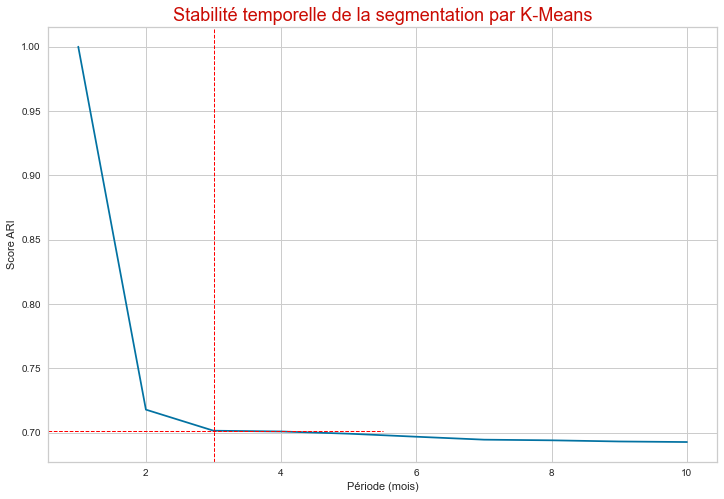

In [19]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="red",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="red",
            ymax=1.80-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="r")
plt.show()

In [20]:
ari_score

,periode,ARI
0,1,1.000000
1,2,0.717794
2,3,0.701405
3,4,0.700802
4,5,0.699078
5,6,0.696722
6,7,0.694442
7,8,0.693932
8,9,0.693032
9,10,0.692600


Remarque :

Sur ce graphique des scores ARI obtenus sur les itérations par période de 2 mois, on remarque <strong>une forte inflexion </strong> après 6 (mois) mois sur les clients initiaux avec un seuil supèrieure à <strong> 0.85%</strong>.

Il faudra donc prévoir la maintenance du programme de segmentation <strong> tous les 6 mois </strong>dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il n'est pas impossible de redéfinir les segments clients à l'avenir.

----------------

-------------------------

Conclusion :


Sur la base de données proposer par "Olist", anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017. Nous avons pu établir les conclusions suivantes :

D'après les méthodes non-supervisées utiliser jusqu'à présent et selon nos connaissances métiers : la méthode du KMeans semble le plus pertinent en terme clustering de données client. En effet , celui-ci est le plus stable et nos offres des meilleurs résultats en terme des résultats de clustering et selon nos différents coefficients utilisés jusqu'à présent. 

    -                  Nb of cluster   	Silhouette	 Gini          
    - OPTICS	                1.0     |	0.868303| 0.498900
    - hierarchical clustering	4.0	|       0.838499| 0.749700
    - k-means	                5.0	|       0.375801| 0.320600
    - Naive modèle	                2.0     |       0.000073| 0.003600
    - DBSCAN	                5.0	|       0.386197| 0.829033

    => Ici, Le DBSCAN et l'Optics sont deux méthodes pas du tout adaptées à notre datastets .

    

Il nous reste le KMeans et le hierarchical clustering :

- Or le Hierarchical clustering nécessite beaucoup plus de temps d'entraînement ainsi qu'un puissance de mémoire plus important que le KMeans.

- Par conséquent, le KMeans semble être la méthode la plus cohérente sur notre projet !
    
=> KMeans =  5 Clusters : 

Remarque : Interprétation métiers de nos Clusters : 
<strong>
- Cluster 0 : clients ayant passé un nombre important de commandes et sont globalement satisfaits. Ils paient ont une seule fois , sont géographiquement moyennement éloigné et ont un délai de livraison très élévés. ==> CLIENTS SATISFAITS (+++) [PREMIUM]

- Cluster 1 : clients étant proches géographiquement avec des délais de livraison très faible. Commande avec nombre d'échéances faible et de petites somme. Les clients sont globalement satisfaits . ==> CLIENTS SATISFAITS(++)[ARGENT]

- Cluster 2 : ce sont les clients globalement mécontents (avis mauvais). Les délais de livraison sont très importants. Ce sont des clients géographiquement très éloignés. Malgré tout, ce sont aussi les clients les plus dépensiers avec un grand nombre d'achats. Le délai de livraison entre chaque commande est moyen. ==> CLIENTS INSATISFAITS (+++) [RED]

- Cluster 3 : ce sont les clients de fin d'année. Paiement en plusieurs fois souvent sur différentes méthodes de paiement avec des achats à montant faibles. Nous avons des délais de livraison assez faibles dans l'ensemble, des clients très satisfaits et géographiquement proche.  == > CLIENTS SATISFAITS(++)[ARGENT]

- Cluster 4 : regroupe les clients qui utilisent un seul moyen de paiement et un nombre faible d'échéances. Ils ont tendance à espacer les délais entre 2 commandes. Les avis de ces clients sont également très bons. ==> CLIENTS SATISFAITS(+)[BRONZE]

</strong>


    => En résumé,nous pouvons observer 4 profils type de clients et 2 comportements : 

        - RED : Très dépensier - malgrè tout [NV] => "Le delai de livraison" pose semble-t-il un souci lorsque les commandes passés passe un certain seuil . 

        - BRONZE : Peu dépensiers - plusieurs méthode de dépenses et/ou plusieurs échéances [V]
        - ARGENT : Peu - Moyennement dépensier - En général une seule méthode de dépenses  - paiements en une seule fois [V]
        - PRENIUM: Moyen - Gros (en 1 ou plusieurs achats ) dépensier - Paiement avec une seule méthode - paiment en une seule fois [V]

        - SATISFAIT[V] ou Non-Satisfait[NV]  => Pas d'intermèdiaire (tout ou rien)




La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

Nota.B : Les différents critères -> Silhouetter |Gini | Rand(Ari) 



- Le coefficient de Gini, ou indice de Gini, est une mesure statistique permettant de rendre compte de la répartition d'une variable (salaire, revenus, patrimoine) au sein d'une population. Autrement dit, il mesure le niveau d'inégalité de la répartition d'une variable dans la population.

- Le [coefficient de Gini](https://fr.wikipedia.org/wiki/Coefficient_de_Gini) est un nombre variant de 0 à 1, où 0 signifie l'égalité parfaite et 1, qui ne peut être atteint, signifierait une inégalité parfaite 

- Coefficient Silhouette

L'analyse de silhouette peut être utilisée pour étudier la distance de séparation entre les clusters résultants. Le diagramme de silhouette affiche une mesure de la proximité de chaque point d'un cluster avec les points des clusters voisins et fournit ainsi un moyen d'évaluer visuellement des paramètres tels que le nombre de clusters.

<strong>Coefficient de silhouette :</strong>

Le coefficient de silhouette ou score de silhouette est une mesure utilisée pour calculer la qualité d'une technique de regroupement. Sa valeur est comprise entre -1 et 1.

1 : Signifie que les grappes sont bien séparées les unes des autres et clairement distinguées.

0 : Signifie que les clusters sont indifférents, ou nous pouvons dire que la distance entre les clusters n'est pas significative.

-1 : Signifie que les clusters sont affectés dans le mauvais sens.


<strong>- ARI</strong>

Un exemple de ces mesures est l'indice de Rand. L'indice de Rand est la proportion de paires de points  (x1,x2) qui sont groupées de la même façon dans les deux partitions : soit parce que, dans les deux cas, x_1 et x_2 appartiennent au même cluster, soit parce que, dans les deux cas,  x_1 et x_2 appartiennent à des clusters différents.

L'indice de Rand peut être gonflé artificiellement en prédisant beaucoup de clusters : les paires de points appartenant à des clusters différents seront nombreuses, et il y aura de grandes chances que deux points étiquetés différemment soient dans deux clusters différents. 

L'indice de Rand ajusté (ARI, pour Adjusted Rand Index) corrige cet effet en normalisant l'indice de Rand (RI) : où E(RI) est l'espérance de la valeur de l'indice de Rand, autrement dit l'indice obtenu en partitionnant les données au hasard. Cet index ajusté est proche de 0 pour un clustering aléatoire, et égal à 1 uniquement quand le clustering correspond exactement à la partition initiale.